# Pachete necesare pentru folosirea acestui Notebook

Vom folosi [scipy](https://scipy.org/), [numpy](https://numpy.org/) și [matplotlib](https://matplotlib.org/).

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import misc, ndimage
from scipy.fft import dctn, idctn
import cv2

# Imaginea cu care lucrăm

Vom folosi o imagine din setul de date oferit implicit de către scipy.

C:\Users\radua\AppData\Local\Temp\ipykernel_29960\866361824.py:1: DeprecationWarning: scipy.misc.ascent has been deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. Dataset methods have moved into the scipy.datasets module. Use scipy.datasets.ascent instead.
  X = misc.ascent()


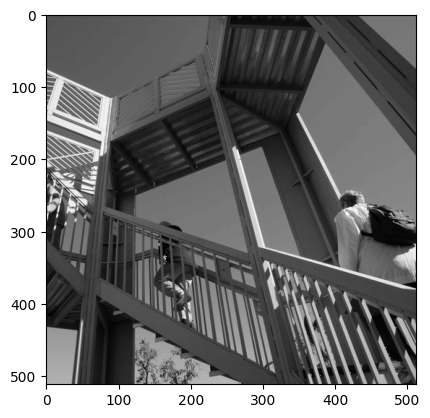

In [15]:
X = misc.ascent()
plt.imshow(X, cmap=plt.cm.gray)
plt.show()

# Transformata DCT a unei imagini

Transformata DCT se extinde la mai multe dimensiuni similar cu transformata DFT. Pentru un semnal bidimensional, precum o imagine, DCT-II devine:

$$
Y_{m_1,m_2} = \sum_{n_1=0}^{N_1-1}
              \sum_{n_2=0}^{N_2-1}
              x_{n_1,n_2}
              \cos\left[\frac{\pi}{N_1}m_1
                \left(n_1 + \frac12\right)\right]
              \cos\left[\frac{\pi}{N_2}m_2\left(n_2 + \frac12\right)\right]
$$

* unde $n_1$ și $n_2$ sunt pozițile pixelilor pe orizontală, respectiv, pe verticală
* bin-urile rezultate corespund pozițiilor pixelilor
* spectrul este în continuare simetric și par
* proprietățile transformatei DCT-II sunt respectate și în cazul celei 2D

În Python avem rutina `scipy.fft.dct` pentru 1D și `scipy.fft.dctn` pentru generalizarea la semnale $n$-dimensionale. Dimensiunea este determinată automat după forma semnalului; tipul DCT poate fi specificat prin atributul `type` (implicit II).

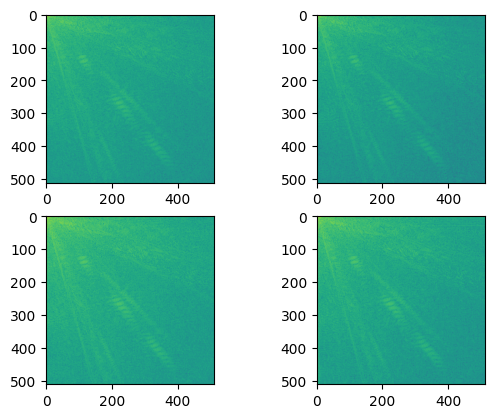

In [3]:
Y1 = dctn(X, type=1)
Y2 = dctn(X, type=2)
Y3 = dctn(X, type=3)
Y4 = dctn(X, type=4)
freq_db_1 = 20*np.log10(abs(Y1))
freq_db_2 = 20*np.log10(abs(Y2))
freq_db_3 = 20*np.log10(abs(Y3))
freq_db_4 = 20*np.log10(abs(Y4))

plt.subplot(221).imshow(freq_db_1)
plt.subplot(222).imshow(freq_db_2)
plt.subplot(223).imshow(freq_db_3)
plt.subplot(224).imshow(freq_db_4)
plt.show()

# Compactarea energiei. Compresie.

Putem profita de proprietatea compresiei energiei prin anularea frecvențelor DCT începând cu *bin*-ul `k` după care aplicăm transformata DCT inversă (similar cu tema anterioară):

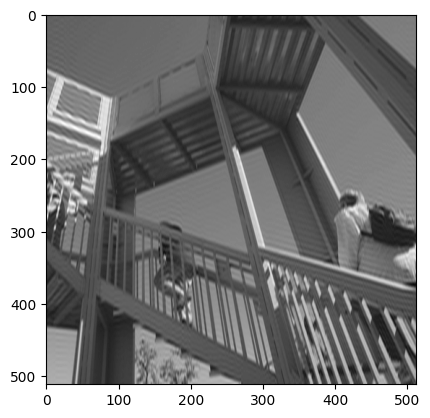

In [4]:
k = 120

Y_ziped = Y2.copy()
Y_ziped[k:] = 0
X_ziped = idctn(Y_ziped)

plt.imshow(X_ziped, cmap=plt.cm.gray)
plt.show()

# JPEG

Algoritmul de compresie JPEG are patru etape:

1. transformarea imaginii din pixeli RGB în Y'CbCr
2. aplicarea 2D-DCT pe blocuri disincte de 8x8 pixeli din imagine
3. cuantizarea în frecvență cu $Q$ dat de standardul JPEG
4. opțional compresia rezultatului cu coduri Huffman

Unde matricea JPEG de cuantizare $Q$ este:
$$
Q =
\begin{bmatrix}
16 & 11 & 10 & 16 & 24 & 40 & 51 & 61 & \\
12 & 12 & 14 & 19 & 26 & 28 & 60 & 55 & \\
14 & 13 & 16 & 24 & 40 & 57 & 69 & 56 & \\
14 & 17 & 22 & 29 & 51 & 87 & 80 & 62 & \\
18 & 22 & 37 & 56 & 68 & 109 & 103 & 77 & \\
24 & 35 & 55 & 64 & 81 & 104 & 113 & 92 & \\
49 & 64 & 78 & 87 & 103 & 121 & 120 & 101\\
72 & 92 & 95 & 98 & 112 & 100 & 103 & 99\\
\end{bmatrix}
$$

Imaginea noastră de test este monocromă, deci nu necesită pasul 1, dar putem efectua o operație de *down-sampling* în preprocesare precum am prezentat la curs.

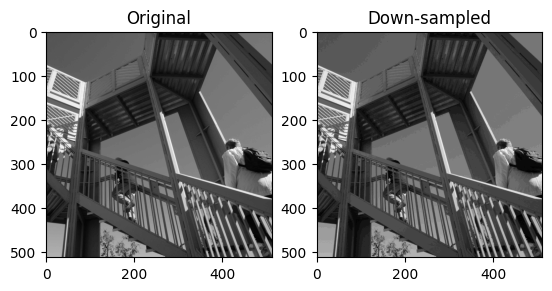

In [5]:
Q_down = 10

X_jpeg = X.copy()
X_jpeg = Q_down*np.round(X_jpeg/Q_down);

plt.subplot(121).imshow(X, cmap=plt.cm.gray)
plt.title('Original')
plt.subplot(122).imshow(X_jpeg, cmap=plt.cm.gray)
plt.title('Down-sampled')
plt.show()

Pentru fiecare bloc de $8\times 8$ aplică DCT și cuantizare.

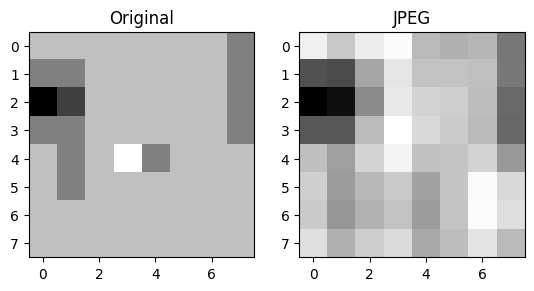

Componente în frecvență:64
Componente în frecvență după cuantizare: 14


In [6]:
Q_jpeg = [[16, 11, 10, 16, 24, 40, 51, 61],
          [12, 12, 14, 19, 26, 28, 60, 55],
          [14, 13, 16, 24, 40, 57, 69, 56],
          [14, 17, 22, 29, 51, 87, 80, 62],
          [18, 22, 37, 56, 68, 109, 103, 77],
          [24, 35, 55, 64, 81, 104, 113, 92],
          [49, 64, 78, 87, 103, 121, 120, 101],
          [72, 92, 95, 98, 112, 100, 103, 99]]

# Encoding
x = X[:8, :8]
y = dctn(x)
y_jpeg = Q_jpeg*np.round(y/Q_jpeg)

# Decoding
x_jpeg = idctn(y_jpeg)

# Results
y_nnz = np.count_nonzero(y)
y_jpeg_nnz = np.count_nonzero(y_jpeg)

plt.subplot(121).imshow(x, cmap=plt.cm.gray)
plt.title('Original')
plt.subplot(122).imshow(x_jpeg, cmap=plt.cm.gray)
plt.title('JPEG')
plt.show()

print('Componente în frecvență:' + str(y_nnz) + 
      '\nComponente în frecvență după cuantizare: ' + str(y_jpeg_nnz))

# Sarcini

1. [6p] Completați algoritmul JPEG incluzând toate blocurile din imagine.

2. [4p] Extindeți la imagini color (incluzând transformarea din RGB în Y'CbCr). Exemplificați pe `scipy.misc.face` folosită în tema anterioară.

3. [6p] Extindeți algoritmul pentru compresia imaginii până la un prag MSE impus de utilizator.

4. [4p] Extindeți algoritmul pentru compresie video. Demonstrați pe un clip scurt din care luați fiecare cadru și îl tratați ca pe o imagine.

C:\Users\radua\AppData\Local\Temp\ipykernel_29960\4144248772.py:35: DeprecationWarning: scipy.misc.ascent has been deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. Dataset methods have moved into the scipy.datasets module. Use scipy.datasets.ascent instead.
  X = misc.ascent()


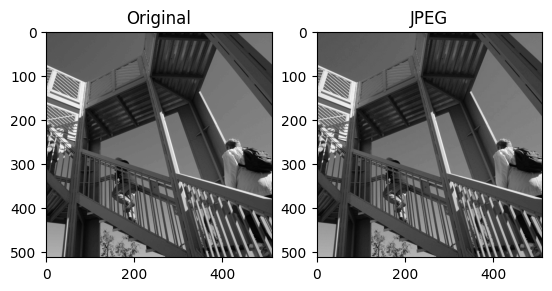

In [7]:
# Sarcina 1
Q_jpeg = [[16, 11, 10, 16, 24, 40, 51, 61],
          [12, 12, 14, 19, 26, 28, 60, 55],
          [14, 13, 16, 24, 40, 57, 69, 56],
          [14, 17, 22, 29, 51, 87, 80, 62],
          [18, 22, 37, 56, 68, 109, 103, 77],
          [24, 35, 55, 64, 81, 104, 113, 92],
          [49, 64, 78, 87, 103, 121, 120, 101],
          [72, 92, 95, 98, 112, 100, 103, 99]]

def jpeg_compress(image: np.array):
    if image.shape[0] % 8 != 0 or image.shape[1] % 8 != 0:
        return
    Y_jpeg = np.zeros_like(image)
    for i in range(image.shape[0] // 8):
        for j in range(image.shape[1] // 8):
            start_row, end_row = 8*i, 8*i + 8
            start_col, end_col = 8*j, 8*j + 8
            x = image[start_row:end_row, start_col:end_col]
            y = dctn(x)
            Y_jpeg[start_row:end_row, start_col:end_col] = np.round(y/Q_jpeg)
    return Y_jpeg

def jpeg_decompress(jpeg: np.array):
    if jpeg.shape[0] % 8 != 0 or jpeg.shape[1] % 8 != 0:
        return
    image = np.zeros_like(jpeg)
    for i in range(jpeg.shape[0] // 8):
        for j in range(jpeg.shape[1] // 8):
            start_row, end_row = 8*i, 8*i + 8
            start_col, end_col = 8*j, 8*j + 8
            image[start_row:end_row, start_col:end_col] = idctn(Q_jpeg*jpeg[start_row:end_row, start_col:end_col])
    return image

X = misc.ascent()
plt.subplot(121).imshow(X, cmap=plt.cm.gray)
plt.title('Original')
plt.subplot(122).imshow(jpeg_decompress(jpeg_compress(X)), cmap=plt.cm.gray)
plt.title('JPEG')
plt.show()

C:\Users\radua\AppData\Local\Temp\ipykernel_29960\2092632150.py:39: DeprecationWarning: scipy.misc.face has been deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. Dataset methods have moved into the scipy.datasets module. Use scipy.datasets.face instead.
  x_face = misc.face()


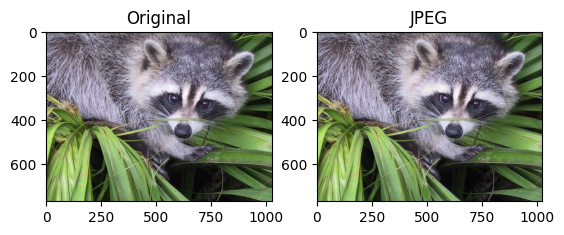

In [8]:
# Cerinta 2

def rgb_to_ycbcr(image: np.array):
    a = np.array([0, 128, 128])
    m = np.array([[0.299, -0.168935, 0.499813],
         [0.587, -0.331665, -0.418531],
         [0.114, 0.50059, -0.081282]])
    return np.round(image.dot(m)) + a

def ycbcr_to_rgb(image: np.array):
    m = np.array([[1,   1,      1],
         [0,   -0.343, 1.765],
         [1.4, -0.711, 0]])
    image = image + np.array([0, -128, -128])
    return np.round(image.dot(m))

def rgb_to_jpeg(image: np.array):
    if (not len(image.shape) == 3 or not image.shape[2] == 3 or
        image.shape[0] % 8 != 0 or image.shape[1] % 8 != 0):
        return
    ycbcr_image = rgb_to_ycbcr(image)
    y_jpeg = jpeg_compress(ycbcr_image[:, :, 0])
    cb_jpeg = jpeg_compress(ycbcr_image[:, :, 1])
    cr_jpeg = jpeg_compress(ycbcr_image[:, :, 2])
    return y_jpeg, cb_jpeg, cr_jpeg

def jpeg_to_rgb(y_jpeg: np.array, cb_jpeg: np.array, cr_jpeg: np.array):
    if not (y_jpeg.shape == cb_jpeg.shape and cb_jpeg.shape == cr_jpeg.shape):
        return
    if y_jpeg.shape[0] % 8 != 0 or y_jpeg.shape[1] % 8 != 0:
        return
    y = jpeg_decompress(y_jpeg)
    cb = jpeg_decompress(cb_jpeg)
    cr = jpeg_decompress(cr_jpeg)
    ycbcr_image = np.array([y, cb, cr]).transpose((1, 2, 0))
    return ycbcr_to_rgb(ycbcr_image).astype(np.uint8())


x_face = misc.face()
y, cb, cr = rgb_to_jpeg(x_face)
decomp = jpeg_to_rgb(y, cb, cr)

plt.subplot(121).imshow(x_face)
plt.title('Original')
plt.subplot(122).imshow(decomp)
plt.title('JPEG')
plt.show()

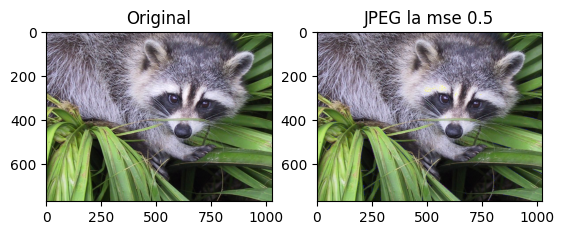

In [9]:
# Cerinta 3
def compress_to_max_mse(image: np.array, max_mse: float):
    jpeg = rgb_to_jpeg(image)
    if jpeg is None:
        return
    while ((jpeg_to_rgb(jpeg[0], jpeg[1], jpeg[2])-image) ** 2).mean() < max_mse:
        jpeg = rgb_to_jpeg(jpeg_to_rgb(jpeg[0], jpeg[1], jpeg[2]))
    return jpeg

a = compress_to_max_mse(x_face, 0.5)
plt.subplot(121).imshow(x_face)
plt.title('Original')
plt.subplot(122).imshow(jpeg_to_rgb(a[0], a[1], a[2]))
plt.title('JPEG la mse 0.5')
plt.show()

In [24]:
# Cerinta 4
def compress_mp4(cap: cv2.VideoCapture):
    compressed_frames = []
    success, image = cap.read()
    count = 0
    while success:
        compressed_frames.append(list(rgb_to_jpeg(image)))
        success, image = cap.read()
    return compressed_frames

def decompress_mp4(compressed_frames, file_name):
    decompressed_frames = []
    for compressed_frame in compressed_frames:
        frame = jpeg_to_rgb(compressed_frame[0], compressed_frame[1], compressed_frame[2])
        decompressed_frames.append(frame)
    video = cv2.VideoWriter(file_name, 0, 24,
                            (decompressed_frames[0].shape[0],
                             decompressed_frames[0].shape[1]))
    for frame in decompressed_frames:
        video.write(frame)
    cv2.destroyAllWindows()
    video.release()

video = cv2.VideoCapture("supermarioinreallife.mp4")
compressed_frames = compress_mp4(video)
decompress_mp4(compressed_frames, "supermarioinreallife_decomp.mp4")